# Problem Statement

Forecast the demand for the fulfillment centers for the next 10 weeks (Weeks: 146-155), based on the  following information -

    - Historical data of demand for a product-center combination (Weeks: 1 to 145)
    - Product(Meal) features such as category, sub-category, current price and discount
    - Information for fulfillment center like center area, city information etc.
    
# Data Dictionary


Weekly Demand Data- 
- **id** -Unique ID
- **week** - week no
- **center_id** - Unique ID for fulfillment center
- **meal_id** - Unique ID for Meal
- **checkout_price** -Final price including discount, taxes & delivery charges
- **base_price** - base price of meal
- **emailer_for_promotion** - Emailer sent for promotion of meal
- **homepage_featured** - Meal featured at homepage
- **num_orders** - (Target) Orders Count

Fulfillment Center Data-
- **center_id** - Unique ID for fulfillment center
- **city_code** - Unique code for city
- **region_code** - Unique code for region
- **center_type** - Anonymized center type
- **op_area** - Area of operation (in km^2)


Meal Information Data-
- **meal_id** - Unique ID for Meal
- **category** - Type of meal (beverages/snacks/soups….)
- **cuisine** - Meal cuisine (Indian/Italian/…)

# Loading Required Libraries and Dataset

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
# reading the data files
train = pd.read_csv('train_GzS76OK/train.csv')
meal_info = pd.read_csv('train_GzS76OK/meal_info.csv')
centre_info = pd.read_csv('train_GzS76OK/fulfilment_center_info.csv')

test = pd.read_csv('test_Kyl30wa.csv')
sample_sub = pd.read_csv('sample_submission_hSlSoT6.csv')

In [69]:
#checking shape
train.shape, meal_info.shape, centre_info.shape

((456548, 9), (51, 3), (77, 5))

# Understanding the Data

### Weekly Demand Data

In [70]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [71]:
train.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

- Week, center_id and meal_id will have a finite number of values.
- 'emailer_for_promotion' and 'homepage_featured' have binary values. 

#### Week Number

In [72]:
train['week'].min(), train['week'].max()

(1, 145)

In [73]:
train['week'].nunique()

145

- The historical data is for a period of 145 weeks, with no week missing in between. 
- We have atleast one row against each week number. 

#### center_id and meal_id

In [74]:
train['center_id'].nunique()

77

In [75]:
(train['center_id'].value_counts()).sort_values()

91     3432
41     4083
162    4366
57     4501
139    4627
       ... 
67     6915
43     6970
52     6993
10     7015
13     7046
Name: center_id, Length: 77, dtype: int64

- There are a total of 77 unique fulfillment centers across the various cities. 
- Each of the store id is present atleast 3432 in the data.

Do each of the stores hold one entry per week? Let us check

In [76]:
train[['week','center_id']].drop_duplicates().shape

(11140, 2)

In [77]:
77*145

11165

If every store had an entry every week, there would be 11165 unique week-center combinations. The unique combinations here are 11140, hence not all stores have entry per week. 

In [78]:
train['meal_id'].nunique()

51

In [79]:
((train['meal_id'].value_counts()).sort_values()).head()

2104    2357
2956    3319
1847    4084
1198    4206
2494    4206
Name: meal_id, dtype: int64

In [80]:
train[['week','meal_id']].drop_duplicates().shape

(7173, 2)

In [81]:
51*145

7395

- Every meal ID does not have a record per week. 
- There were some meal ID which were not sold in a particular week and do not hold any entry in the weekly demand data.

#### checkout_price and base_price

In [82]:
train[['checkout_price', 'base_price']].describe()

,checkout_price,base_price
count,456548.000000,456548.000000
mean,332.238933,354.156627
std,152.939723,160.715914
min,2.970000,55.350000
25%,228.950000,243.500000
50%,296.820000,310.460000
75%,445.230000,458.870000
max,866.270000,866.270000


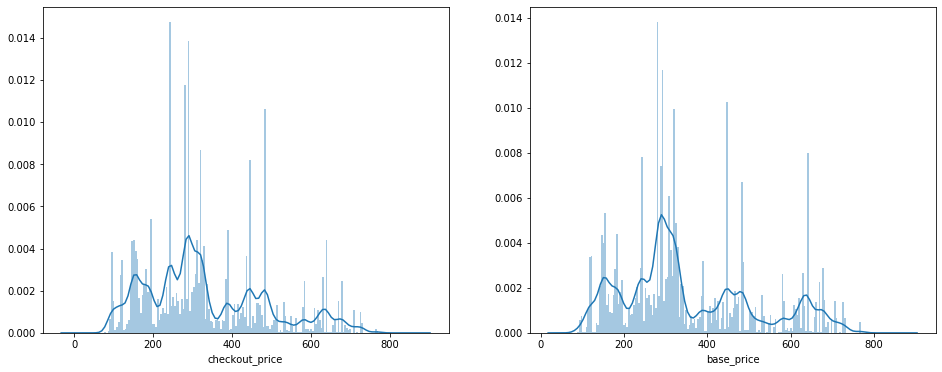

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

sns.distplot(train['checkout_price'], kde = True, bins = 200, ax = ax1)
sns.distplot(train['base_price'], kde = True, bins = 200, ax = ax2)

plt.show()

The two variables almost have almost the same distributions. Most of the values lie in the range of 200 to 400 in both plots. 

#### emailer_for_promotion and homepage_featured

In [84]:
train['emailer_for_promotion'].value_counts(normalize=True)

0    0.918848
1    0.081152
Name: emailer_for_promotion, dtype: float64

In [85]:
train['homepage_featured'].value_counts(normalize=True)

0    0.8908
1    0.1092
Name: homepage_featured, dtype: float64

#### Target variable - number of orders

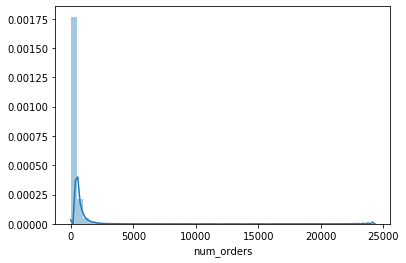

In [112]:
sns.distplot(train['num_orders'])

In [113]:
(train.loc[train['num_orders']>2000]).shape

(3400, 9)

The data is highly skewed. There are about 3400 datapoints () having 'num_orders' more than 2000. Let us apply a log transformation and look at the distribution.

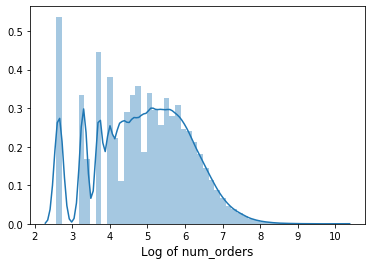

In [114]:
# log transformed UNITS column
sns.distplot(np.log(train['num_orders'].values))
plt.xlabel('Log of num_orders', fontsize=12)
plt.show()

After log transformation it looks close to a normal distribution.

### Fulfillment Center Data

In [115]:
centre_info.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [116]:
centre_info.dtypes

center_id        int64
city_code        int64
region_code      int64
center_type     object
op_area        float64
dtype: object

#### center_id

In [117]:
centre_info['center_id'].nunique()

77

In [118]:
len(set(centre_info['center_id']).intersection(set(train['center_id'])))

77

The number of unique center ID is same in both - weekly data and center information. And these 77 IDs are exactly the same for both the datasets  

#### city_code and region_code

In [119]:
centre_info['city_code'].nunique()

51

In [120]:
(centre_info['city_code'].value_counts()).head()

590    9
526    8
638    3
593    2
517    2
Name: city_code, dtype: int64

In [121]:
centre_info['region_code'].nunique()

8

The Fulfillment centers are spread over 51 cities and 8 regions. City codes 590 and 526 have 9 and 8 centers respectively. Other cities have 3 or less. 

#### center_type and op_area

In [122]:
centre_info['center_type'].value_counts()

TYPE_A    43
TYPE_C    19
TYPE_B    15
Name: center_type, dtype: int64

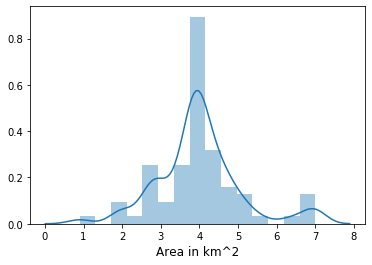

In [123]:
sns.distplot(centre_info['op_area'])
plt.xlabel('Area in km^2', fontsize=12)
plt.show()

### Meal Info Data

In [98]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [99]:
meal_info.dtypes

meal_id      int64
category    object
cuisine     object
dtype: object

#### meal_info

In [106]:
meal_info['meal_id'].nunique()

51

In [107]:
len(set(meal_info['meal_id']).intersection(set(train['meal_id'])))

51

In [108]:
meal_info['category'].nunique()

14

In [109]:
meal_info['category'].value_counts()

Beverages       12
Desert           3
Salad            3
Pizza            3
Biryani          3
Soup             3
Starters         3
Rice Bowl        3
Sandwich         3
Pasta            3
Fish             3
Extras           3
Seafood          3
Other Snacks     3
Name: category, dtype: int64

In [110]:
meal_info['cuisine'].nunique()

4

In [124]:
meal_info['cuisine'].value_counts()

Thai           15
Continental    12
Indian         12
Italian        12
Name: cuisine, dtype: int64

The data consists of four variety of cuisines, which are further divided into sub-categories like beverage, starters etc. There are a total of 12 such categories.

## Merging the datasets

In [127]:
train_meal_data = train.merge(meal_info, how = 'left', on='meal_id')
train_data = train_meal_data.merge(centre_info, how = 'left', on = 'center_id')

In [128]:
train.shape, meal_info.shape, centre_info.shape, train_data.shape

((456548, 9), (51, 3), (77, 5), (456548, 15))

In [129]:
test_meal_data = test.merge(meal_info, how = 'left', on='meal_id')
test_data = test_meal_data.merge(centre_info, how = 'left', on = 'center_id')

In [130]:
test.shape, meal_info.shape, centre_info.shape, test_data.shape

((32573, 8), (51, 3), (77, 5), (32573, 14))

#### Base price and number of orders

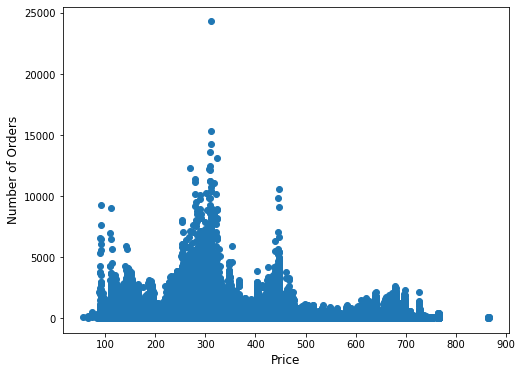

In [131]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (train_data['base_price']), y = (train_data['num_orders']))
plt.xlabel('Price', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

Sales are higher for products with lower price. Does the category of meal have any significant impact on the sales? Let us look at the average orders for different categories.

#### Category and number of orders

In [130]:
(train_data.groupby(['category'])['num_orders'].mean())

category
Beverages       316.526116
Biryani          30.651402
Desert           66.250905
Extras          293.834169
Fish             85.595268
Other Snacks    162.234691
Pasta            59.137142
Pizza           222.817309
Rice Bowl       624.822288
Salad           383.218460
Sandwich        529.776276
Seafood         100.895898
Soup             82.023353
Starters        155.276110
Name: num_orders, dtype: float64

In [131]:
(train_data.groupby(['category'])['num_orders'].mean()).sort_values()

category
Biryani          30.651402
Pasta            59.137142
Desert           66.250905
Soup             82.023353
Fish             85.595268
Seafood         100.895898
Starters        155.276110
Other Snacks    162.234691
Pizza           222.817309
Extras          293.834169
Beverages       316.526116
Salad           383.218460
Sandwich        529.776276
Rice Bowl       624.822288
Name: num_orders, dtype: float64

Rice bowl and Sandwiches have a significantly higher demand (orders) while the biryani and desert have comparatively lower number of orders.

#### Center type and Area

In [132]:
(train_data.groupby(['center_type'])['num_orders'].mean()).sort_values()

center_type
TYPE_C    206.670097
TYPE_A    262.394456
TYPE_B    318.856145
Name: num_orders, dtype: float64

Fulfillment centers with Type A always have a higher number of orders. Is there a difference in the size of the centers of type a, b and c? Lets check

In [133]:
train_data['op_area']

0         2.0
1         2.0
2         2.0
3         2.0
4         2.0
         ... 
456543    4.5
456544    4.5
456545    4.5
456546    4.5
456547    4.5
Name: op_area, Length: 456548, dtype: float64

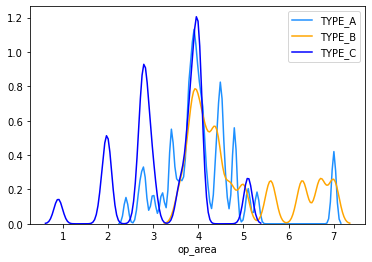

In [134]:
type_a = train_data.loc[train_data['center_type'] == 'TYPE_A']
type_b = train_data.loc[train_data['center_type'] == 'TYPE_B']
type_c = train_data.loc[train_data['center_type'] == 'TYPE_C']


sns.distplot(type_a['op_area'], hist = False,color= 'dodgerblue', label= 'TYPE_A')
sns.distplot(type_b['op_area'], hist = False,  color= 'orange', label= 'TYPE_B')
sns.distplot(type_c['op_area'], hist = False,  color= 'blue', label= 'TYPE_C')


# Preprocessing

In [135]:
# Checking presence of missing values in the data
train_data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [136]:
test_data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [137]:
# Handling categorical variables
train_data = pd.get_dummies(train_data)
train_data.shape

(456548, 33)

In [138]:
test_data = pd.get_dummies(test_data)
test_data.shape

(32573, 32)

## Creating Train and Validation Sets

Train set: Week 1 to Week 134

Validation: Week 135 to 145

In [139]:
(train_data.loc[train_data['week']==135]).head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
420466,1455692,135,55,1885,150.41,149.41,0,0,216,647,...,0,0,0,0,0,0,1,0,0,1
420467,1136764,135,55,1993,150.35,150.35,0,0,134,647,...,0,0,0,0,0,0,1,0,0,1
420468,1492008,135,55,2539,150.35,151.35,0,0,96,647,...,0,0,0,0,0,0,1,0,0,1
420469,1496190,135,55,2631,97.06,163.93,0,0,134,647,...,0,0,0,0,1,0,0,0,0,1
420470,1389813,135,55,1248,93.15,164.93,0,0,26,647,...,0,0,0,0,1,0,0,0,0,1


In [140]:
train_ = train_data[0:420466]
valid_ = train_data[420466:]

In [141]:
train_x = train_.drop('num_orders', axis=1)
train_y = train_['num_orders']
valid_x = valid_.drop('num_orders', axis=1)
valid_y = valid_['num_orders']

In [142]:
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((420466, 32), (420466,), (36082, 32), (36082,))

# Evaluation Metric

In [143]:
# function to calculate the root mean squared log error
from sklearn.metrics import mean_squared_log_error as msle
def get_rmsle(true, predicted) :
    
    return 100*np.sqrt(msle(true, predicted))

# Baseline Model

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [146]:
model_lr = LinearRegression(normalize=True)

In [147]:
model_lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [148]:
pred_lr = model_lr.predict(valid_x)

In [150]:
pred_lr = pd.DataFrame(pred_lr, columns = ['lr'])
pred_lr['lr'] = pred_lr['lr'].apply(lambda x: 0 if x<0 else x)

In [168]:
get_rmsle(valid_y, pred_lr['lr'])

168.94393265703295

# Decision Tree

In [152]:
model_dt = DecisionTreeRegressor(max_features = 0.5, max_depth=7, random_state=0)

In [153]:
model_dt.fit(train_x, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=0.5,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [154]:
pred_dt = model_dt.predict(valid_x)

In [155]:
get_rmsle(valid_y, pred_dt)

91.85125745571428

# Advanced Ensemble Models

### Random Forest model 

In [156]:
model_rf = RandomForestRegressor(n_estimators = 100, max_depth =7, random_state=1)

In [157]:
model_rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [158]:
pred_rf = model_rf.predict(valid_x)

In [159]:
get_rmsle(valid_y, pred_rf)

85.50826770663437

### XGBoost Model

In [160]:
model_XGB = xgb.XGBRegressor(n_estimators = 200, max_depth = 8,random_state = 0)

In [161]:
model_XGB.fit(train_x, train_y)

[17:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [162]:
pred_xgb= model_XGB.predict(valid_x)
pred_xgb = pd.DataFrame(pred_xgb, columns = ['xgb'])
pred_xgb['xgb'] = pred_xgb['xgb'].apply(lambda x: 0 if x<0 else x)

In [163]:
get_rmsle(valid_y, pred_xgb['xgb'])

64.04724805410989

## Weighted Averaging

In [169]:
from statistics import mean
final_pred = np.array([])
for i in range(0,len(valid_x)):
    final_pred = np.append(final_pred, mean([pred_rf[i], pred_xgb['xgb'][i], pred_xgb['xgb'][i]]))

In [170]:
get_rmsle(valid_y, final_pred)

63.405669575574706

In [164]:
model_lr = LinearRegression(normalize=True)

In [165]:
model_lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [166]:
pred_lr = model_lr.predict(valid_x)

In [167]:
pred_lr = pd.DataFrame(pred_lr, columns = ['lr'])
pred_lr['lr'] = pred_lr['lr'].apply(lambda x: 0 if x<0 else x)

In [168]:
get_rmsle(valid_y, pred_lr['lr'])

168.94393265703295